# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import cv2
# Load pickled data
import pickle
import numpy as np

training_file = "train.p"
validation_file= "valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of valid examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 34799
Number of valid examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

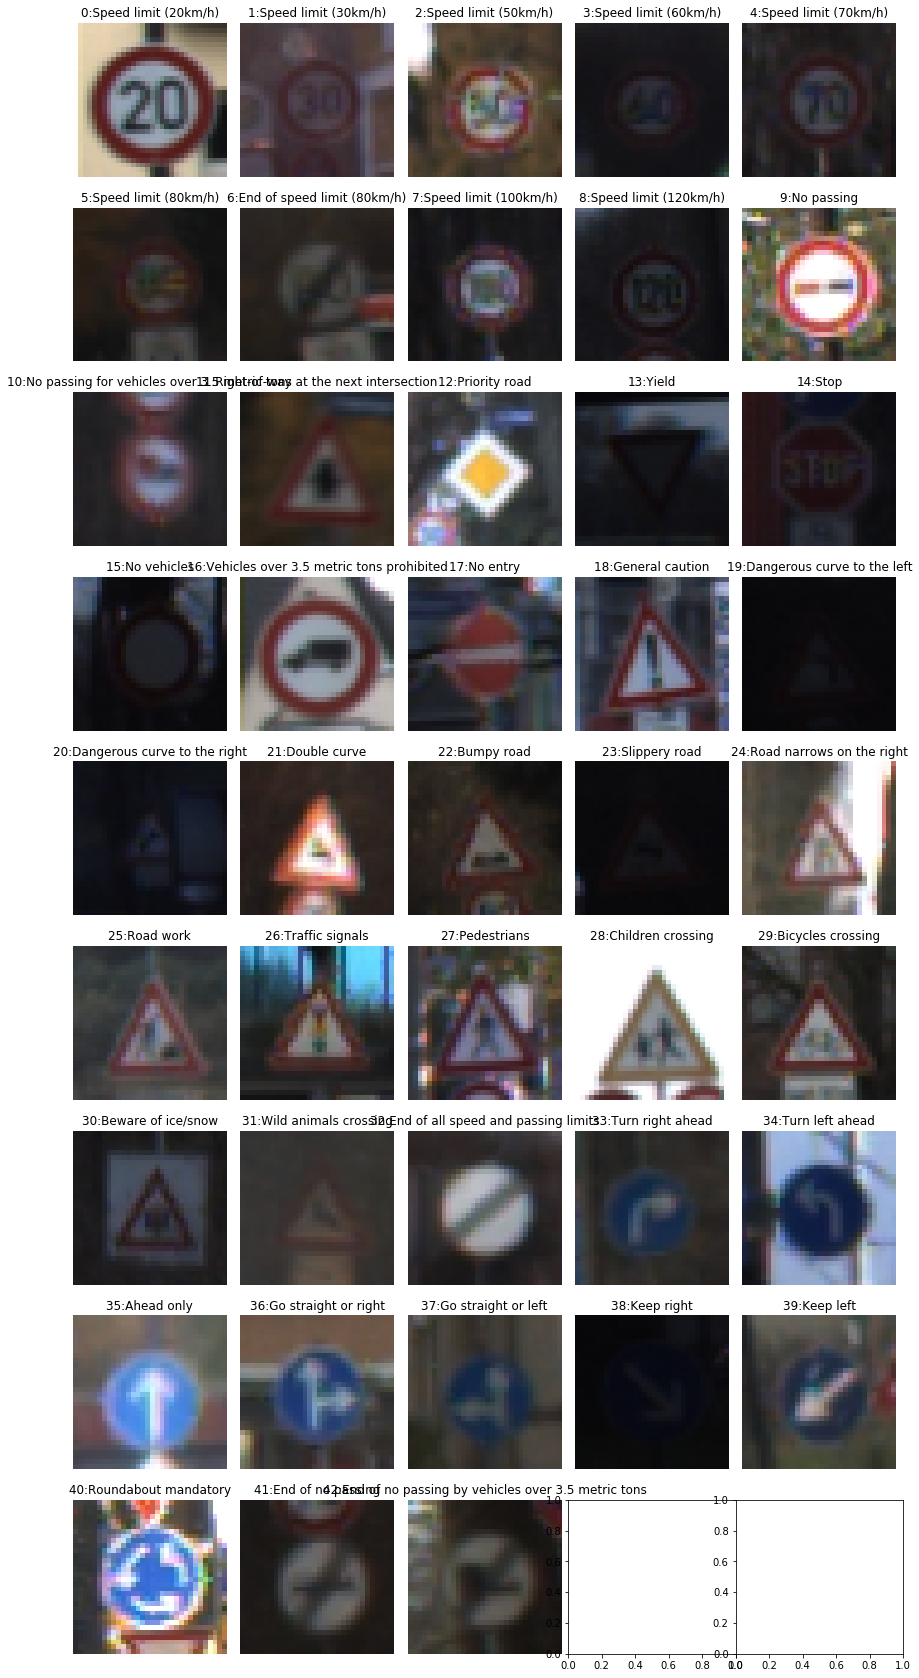

In [4]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import pandas as pd
sign_names = pd.read_csv('signnames.csv')

# show images in classes. one class shows one image 
fig, axs = plt.subplots(9,5, figsize=(15, 30))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
done = []

for index, class_id in enumerate(train['labels']):
    if class_id not in done:
        class_name = sign_names.iloc[class_id]['SignName']
        done.append(class_id)
        image = train['features'][index,:,:,:]
        axs[class_id].axis('off')
        axs[class_id].imshow(image)
        axs[class_id].set_title("%s:%s" % (class_id, class_name))
    else:
        continue


We can see that the brightness of images is very different. This increases the complexity of prediction. We can use gray scaling to eliminate this problem. 


### Distribution of images in the classes

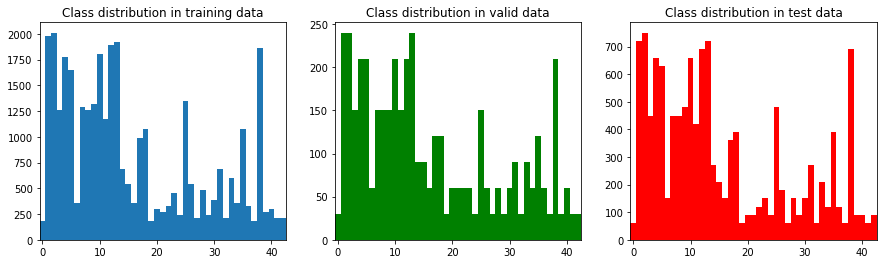

In [7]:
def plot_dist(y_data, title=None, ax=None, **kwargs) :
    ax.hist(y_data, np.arange(-0.5, n_classes+1.5), stacked=True, **kwargs)
    ax.set_xlim(-0.5,n_classes-0.5)
    ax.set_title(title)

fig,ax = plt.subplots(1,3, figsize=(15,4))
plot_dist(y_train, title='Class distribution in training data', ax=ax[0])
plot_dist(y_valid, title='Class distribution in valid data', ax=ax[1], color='green')
plot_dist(y_test, title='Class distribution in test data', ax=ax[2], color='red')

We can see that the class distribution in train and test sets is similary. Besides, the train dataset is not balanced, which may decreases the accuracy of the model predicting. This problem can be sovled by data augmenting.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

In [8]:
# setup tensorflow
import tensorflow as tf
from tensorflow.contrib.layers import flatten


As a first step, I decided to convert the images to grayscale because the brightness of samples are different, and the brightness between the training data and reality images are also different. However, the brightness of image is no relation  with the content of image. This means that the brightness of image increases the complexity of predicting. The gray scale can eliminate this effect, and make predicting accuracy improve.

Secondly, I decided to generate additional data because the training dataset is unbalanced, which makes some classes hard to be predicted. With additional data, we can get a robustly model.   

To add more data to the the data set, I used the image brightness and image transforming techniques. 

The difference between the original data set and the augmented data set is the brightness and transform angle of image. 

As a last step, I normalized the image data because it can make different features similar distributionbs which benifits to the training and accuracy. 

In [9]:
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    # Brightness

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)

    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))

    return img


def data_augmenting(image):
    image1 = transform_image(image,20,10,5)
    image2 = augment_brightness_camera_images(image1)
    new_img = image2
    return new_img


MIN_CLASS_ITEM_NUMBER = 500
for class_n in range(n_classes):
    class_indices = np.where(y_train == class_n)
    n_samples = len(class_indices[0])
    if n_samples < MIN_CLASS_ITEM_NUMBER:
        print("augment class %s" % str(class_n))
        for i in range(MIN_CLASS_ITEM_NUMBER - n_samples):
            new_img = X_train[class_indices[0][i % n_samples]]
            new_img = data_augmenting(new_img)
            X_train = np.concatenate((X_train, [new_img]), axis=0)
            y_train = np.concatenate((y_train, [class_n]), axis=0)



augment class 0
augment class 6
augment class 14
augment class 15
augment class 16
augment class 17
augment class 19
augment class 20
augment class 21
augment class 22
augment class 23
augment class 24
augment class 26
augment class 27
augment class 28
augment class 29
augment class 30
augment class 31
augment class 32
augment class 33
augment class 34
augment class 36
augment class 37
augment class 39
augment class 40
augment class 41
augment class 42


Here is an example of an original image and augmented images:


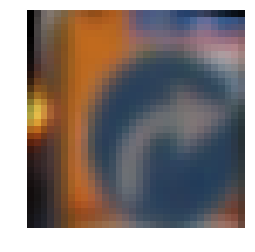

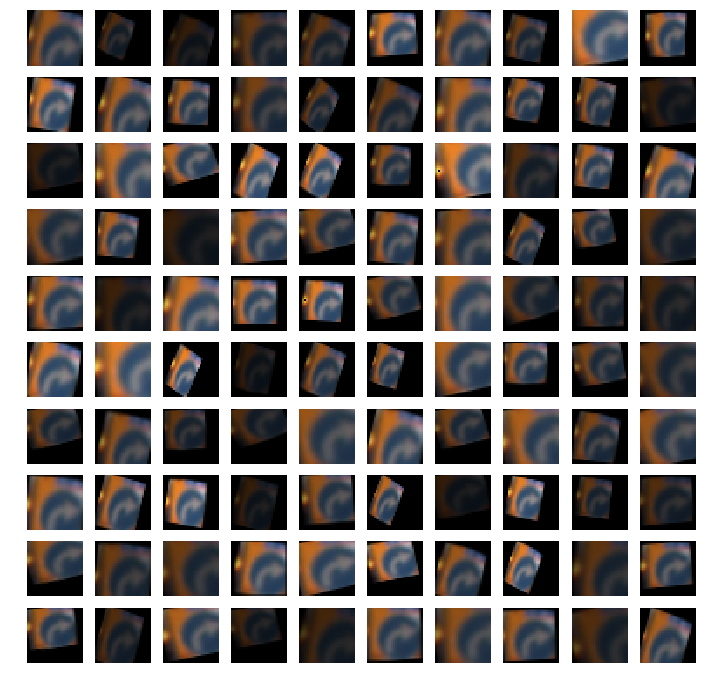

In [11]:
# show augmenting results
image = X_train[0,:,:,:]
plt.imshow(image);
plt.axis('off');

import matplotlib.gridspec as gridspec
gs1 = gridspec.GridSpec(3, 3)
gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes.
plt.figure(figsize=(12,12))
for i in range(9):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    img = data_augmenting(image)

    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.axis('off')

plt.show()

In [12]:

def grayscale(images): 
    res = np.sum(images/3, axis=3, keepdims=True)
    return res


X_train_rgb = np.copy(X_train)
X_train = grayscale(X_train)
X_train_gry = np.copy(X_train)

X_valid = grayscale(X_valid)
X_test = grayscale(X_test)



Here is an example of a traffic sign image before and after grayscaling.

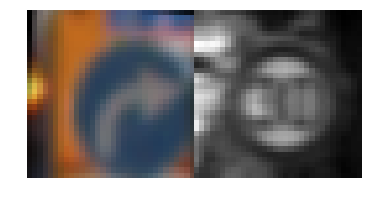

In [13]:
# Visualize rgb vs grayscale
fig, axs = plt.subplots(1,2, figsize=(6, 9))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
image_rgb = X_train_rgb[0,:,:,:]
axs[0].axis('off')
axs[0].imshow(image_rgb)
image_gry = X_train_gry[1,:,:,:].squeeze()
axs[1].axis('off')
axs[1].imshow(image_gry, cmap = 'gray')

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [14]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

def normalize(X):
    return (X - 128)/128

X_train_unnorm = np.copy(X_train)
X_train = normalize(X_train)
X_valid = normalize(X_valid)
X_test = normalize(X_test)


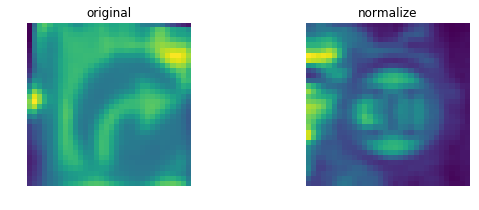

In [15]:
# show normalized results
fig, axs = plt.subplots(1,2, figsize=(10, 3))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
image_unnorm = X_train_unnorm[0].squeeze()
axs[0].axis('off')
axs[0].set_title('original')
axs[0].imshow(image_unnorm)
image_norm = X_train[1].squeeze()
axs[1].axis('off')
axs[1].set_title('normalize')
axs[1].imshow(image_norm)

As a last step, I use shuffling function to randomize train datasets and valid datasets. The images in training dataset and valid datasets were taken from the same vehicle at close intervals, thus the adjacent images are similar. Shuffling them before training can break their connectings and hugely improve the finally performance.


In [16]:
print(y_train[0:500])


[33  1 13 17 26 41 34 14  8 37 32  1 16 35 11 10 35  0 33 25 38 38  0 20 30
  1 19 26 28 25 34 10 18 39  4 34 26  7  8 20 14 19 24  6 38 19  2 23  9  6
 28 31  5  4  4 37 11  9 22 36  2 13  8  1  7 33 28 42 41 38 35 24 25 31 28
 36  5 39 34 19 34 21 12  7 13 17 11  0  2 30 16 19  7  5  3 25 20 10 13 25
 16 11 13 12 29  5 37 31  4 25 38 16 33 12  4 14  7 33 22  9 17  5  7  2  3
 12 24  6 15  4  1 38 33 37 38 38  4 41 24 27  6  1 25  8 26 41 12  8 36 34
 31  0  5 22 36 22 41 10 39 33  7  6  2 12 21 30 15 21 25 12 11  6 14 22 27
 36 33 16 42  2 37 32 34 13 34 13 36 26 34 40 38 25 18 36 33  1 38 36  8 22
 30 23  5 18 26 38  1 28 42 13 22 12  5 30 36 15 20 20 29 38  9 13  4 29 13
  5  1  5 27 22 15 13  3 12  4 25 39  7 37 18 10  0 34 10 10 39 30 11  1  0
 29 34 24 35 36 15 23  5 13 21 34 39 38  8 20 21  2  3  3  0 35 31  2  1  0
 13 29  5 23  8 32  7 40 41  1  1  1 15 10  7 23 15 25  5 37 32 16  9 38 25
 38 41  3 37  7 24 32  1 18 17 14 26  0 12  8 19 38 11  0 12 39 28 32  9 27
 34 35 42 26

**obviously, the dataset need to be shuffled**


In [17]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)
print(y_train[0:500])

[42 32  0  7 17 38 36  4 28 34  4 29 13 20 10 26 15 39  6 30 17 35  4 35  1
 12 16 21  2 42 40 10  4 38  1  4  8 14 21 40 15 12  0 35  0 36  9  1  8 27
 11 20  5 34 21 29 17  0 11 28 13 20  2 42  4 23 26 13 19 41  5 13 34 25 15
  7 40 25 22  8 25 11 22 27  6 32 22 12 23  1 32  8 40 38 11 13 40 17 15  3
 28  4 10  5 26  4 11  2 25 37 11 33 29  5 30 12 25 11  6 13  7  1 38  9 16
 19 36  0 30  2 36 25  7  4 21  1 11  3  5 16  4 19 23  2 18  2 16  1 20 40
 34 25 15 27 25 20 15  2  9  8 37 33 28 30 29 36 19 15  4 38 26 41 13  1 36
  1 37 29 13 38 23  3  8 11 16 28 27 42  6 38  1 27 22 41 15 35 38 25 25 42
  7 10 16  5 27  9  4 36 20  1 12 14 31 27 31 21  6 19 42 29  0 27 13 36 21
 17 12 15 30 24 32  0 34 36  3  1 16  7 24 29  8 13  2 24 31 10 41 27  9 13
  2 19  2 23 28 38  9 35  1  5 30 18  1  1 13 33 38 22 38 42 12 20  7 10 24
 15 41 12 38 42 17 16  1 36 28  3  5 30 37  8 22  2 27  3 12 15 20 12 18 13
 32 42 36 13 36 34  2 22  4 17 36 13 29 15  5 38 12 13  7  5 28 20 41 12 13
 23 33 24 10

### Model Architecture

In [18]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
def LeNet(x, input_shape, n_classes):    
    # Hyperparameters
    mu = 0
    sigma = 0.1

    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, input_shape[2], 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)

    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b

    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b

    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b

    return logits

In [30]:
def LeNet_dropout_merge(x, input_shape, n_classes, keep_prob):    
    # Hyperparameters
    mu = 0
    sigma = 0.1

    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, input_shape[2], 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    layer2 = conv2
    
    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)

    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b

    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    layer3 = fc1
    
    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
       
    layer2flat = flatten(layer2)
    layer3flat = flatten(layer3)
    
    merged = tf.concat_v2([layer3flat, layer2flat], 1)

    # SOLUTION: Activation.
    fc2    = tf.nn.relu(merged)
    fc2_drop = tf.nn.dropout(fc2, keep_prob)
    
    
    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    #fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(520, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2_drop, fc3_W) + fc3_b

    return logits

# Note: alexnet, VGG arch should be tried


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [31]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

EPOCHS = 100 # increase epochs number until it can't improve moedl accuracy.
BATCH_SIZE = 128
lr = 0.001
KEEP_PROB = 0.5

x = tf.placeholder(tf.float32, (None,X_train.shape[1], X_train.shape[2], X_train.shape[3]))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

logits = LeNet_dropout_merge(x, input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]),\
                       n_classes=n_classes, keep_prob = keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = lr)
training_operation = optimizer.minimize(loss_operation)
saver = tf.train.Saver()


### evaluate

In [32]:

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### start training

In [43]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print("START TRAINING...")
    EPOCHS = 30
    for i in range(EPOCHS):
        print("EPOCH {} ...".format(i+1))
        for offset in range(0, n_train, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: KEEP_PROB})
        
        train_accuracy = evaluate(X_train, y_train)        
        validation_accuracy = evaluate(X_valid, y_valid)
        test_accuracy = evaluate(X_test, y_test)
        print("Train Loss, Train Accuracy = {:.3f}, \
        Validation Accuracy = {:.3f}\
        Test Accuracy = {:.3f}\
        ".format(train_accuracy, validation_accuracy, test_accuracy))
    saver.save(sess, './lenet')       

START TRAINING...
EPOCH 1 ...
Train Loss, Train Accuracy = 0.603,         Validation Accuracy = 0.705        Test Accuracy = 0.711        
EPOCH 2 ...
Train Loss, Train Accuracy = 0.722,         Validation Accuracy = 0.835        Test Accuracy = 0.832        
EPOCH 3 ...
Train Loss, Train Accuracy = 0.777,         Validation Accuracy = 0.875        Test Accuracy = 0.866        
EPOCH 4 ...
Train Loss, Train Accuracy = 0.811,         Validation Accuracy = 0.909        Test Accuracy = 0.886        
EPOCH 5 ...
Train Loss, Train Accuracy = 0.831,         Validation Accuracy = 0.916        Test Accuracy = 0.894        
EPOCH 6 ...
Train Loss, Train Accuracy = 0.847,         Validation Accuracy = 0.920        Test Accuracy = 0.895        
EPOCH 7 ...
Train Loss, Train Accuracy = 0.863,         Validation Accuracy = 0.928        Test Accuracy = 0.906        
EPOCH 8 ...
Train Loss, Train Accuracy = 0.869,         Validation Accuracy = 0.927        Test Accuracy = 0.906        
EPOCH 9 ...
Tr

In [34]:
# count the number of items in labels

from collections import Counter
label_count = Counter(y_train)

# select a part of dataset being a mini dataset to find the right net arch or tune the parameters
def mini_dataset(selected_classes, X_train, y_train):
    assert type(selected_classes) == list
    mini_X = []
    mini_y = []                                                                                                                                      
    for i, item in enumerate(y_train):
        if item in selected_classes:
            mini_X.append(X_train[i])
            mini_y.append(y_train[i])
    return np.array(mini_X), np.array(mini_y)



In [44]:
def debug_class(X_class, y_class,sess):
    for class_id in set(y_class):
        mini_X, mini_y = mini_dataset([class_id], X_class, y_class)
        accuracy = sess.run(accuracy_operation, feed_dict={x: mini_X, y: mini_y, keep_prob: 1})
        print("class id %s has %s samples. accuracy is %s" % (str(class_id), str(label_count[class_id]), str(accuracy)))

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "./lenet")
    debug_class(X_valid, y_valid,sess)    


class id 0 has 1000 samples. accuracy is 0.933333
class id 1 has 1980 samples. accuracy is 0.954167
class id 2 has 2010 samples. accuracy is 0.9875
class id 3 has 1260 samples. accuracy is 1.0
class id 4 has 1770 samples. accuracy is 1.0
class id 5 has 1650 samples. accuracy is 0.957143
class id 6 has 1000 samples. accuracy is 1.0
class id 7 has 1290 samples. accuracy is 0.92
class id 8 has 1260 samples. accuracy is 0.96
class id 9 has 1320 samples. accuracy is 0.986667
class id 10 has 1800 samples. accuracy is 1.0
class id 11 has 1170 samples. accuracy is 0.96
class id 12 has 1890 samples. accuracy is 0.980952
class id 13 has 1920 samples. accuracy is 0.995833
class id 14 has 1000 samples. accuracy is 0.988889
class id 15 has 1000 samples. accuracy is 0.988889
class id 16 has 1000 samples. accuracy is 0.8
class id 17 has 1000 samples. accuracy is 0.916667
class id 18 has 1080 samples. accuracy is 0.908333
class id 19 has 1000 samples. accuracy is 1.0
class id 20 has 1000 samples. accu

Add validation data into train data to get a better performance.

In [45]:
with tf.Session() as sess:
    saver.restore(sess, "./lenet")
    print("START TRAINING...")
    
    X_train_valid = np.concatenate((X_train, X_valid), axis=0)
    y_train_valid = np.concatenate((y_train, y_valid), axis=0)
    X_train_valid, y_train_valid = shuffle(X_train_valid, y_train_valid)
    n_train = len(y_train_valid)
    
    for i in range(30):
        print("EPOCH {} ...".format(i+1))
        for offset in range(0, n_train, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_valid[offset:end], y_train_valid[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
        
        train_accuracy = evaluate(X_train_valid, y_train_valid)        
        test_accuracy = evaluate(X_test, y_test)
        print("Train Loss, Train Accuracy = {:.3f}, \
        Test Accuracy = {:.3f}\
        ".format(train_accuracy, test_accuracy))
    saver.save(sess, './lenet')       
 

START TRAINING...
EPOCH 1 ...
Train Loss, Train Accuracy = 0.814,         Validation Accuracy = 0.896        Test Accuracy = 0.846        
EPOCH 2 ...
Train Loss, Train Accuracy = 0.636,         Validation Accuracy = 0.770        Test Accuracy = 0.729        
EPOCH 3 ...
Train Loss, Train Accuracy = 0.769,         Validation Accuracy = 0.903        Test Accuracy = 0.838        
EPOCH 4 ...
Train Loss, Train Accuracy = 0.840,         Validation Accuracy = 0.951        Test Accuracy = 0.885        
EPOCH 5 ...
Train Loss, Train Accuracy = 0.795,         Validation Accuracy = 0.945        Test Accuracy = 0.873        
EPOCH 6 ...
Train Loss, Train Accuracy = 0.862,         Validation Accuracy = 0.986        Test Accuracy = 0.908        
EPOCH 7 ...
Train Loss, Train Accuracy = 0.896,         Validation Accuracy = 0.997        Test Accuracy = 0.930        
EPOCH 8 ...
Train Loss, Train Accuracy = 0.898,         Validation Accuracy = 0.998        Test Accuracy = 0.930        
EPOCH 9 ...
Tr

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

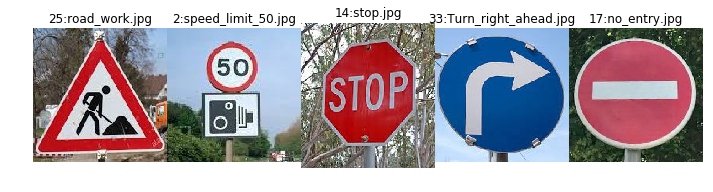

In [141]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import glob
img_files = glob.glob('web_test_dataset/*.jpg')
#not_entry_image = "web_test_dataset/no_entry.jpg"
n_new = len(img_files)
new_data = np.zeros((n_new, 32,32,3), dtype=np.uint8)

fig, ax = plt.subplots(1,n_new, figsize = (12,15))
fig.subplots_adjust(hspace = .2, wspace=.001)
for i in range(n_new) :
    img = plt.imread(img_files[i])
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(img_files[i].split("/")[1])
    img = cv2.resize(img, (32,32), interpolation=cv2.INTER_AREA) # resize to 32x32
    new_data[i] = img


### Predict the Sign Type for Each Image

In [152]:
def predict(X_data, top_k = 5):
    with tf.Session() as sess:
        saver.restore(sess, "./lenet")
        sess = tf.get_default_session()
        #preprocess
        X_gry = grayscale(X_data)
        X_norm = normalize(X_gry)
        X = X_norm
        #predict
        results = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k = top_k),
                       feed_dict={x: X, keep_prob: 1})
        return results

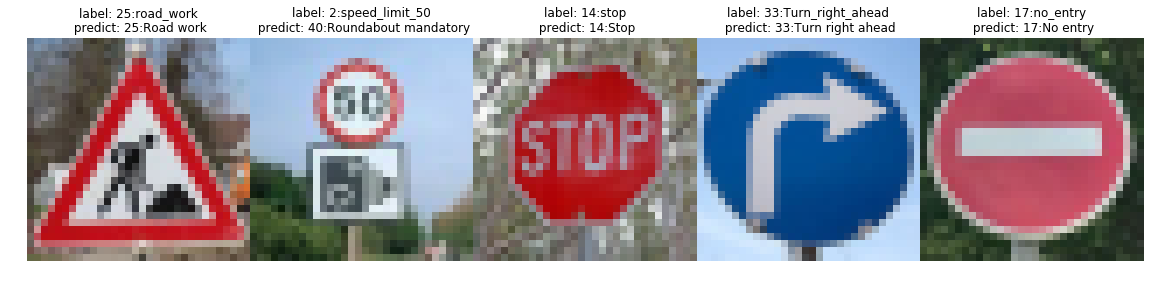

In [153]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

results = predict(new_data)
probs, indices = results
predicts = list(map(lambda x: x[0], indices))
fig, axs = plt.subplots(1,len(indices), figsize=(20, 30))
fig.subplots_adjust(hspace = .2, wspace=.001)
ax = axs.ravel()

for i, ind in enumerate(predicts):
    img = new_data[i]
    ax[i].imshow(img)
    ax[i].axis('off')
    label = img_files[i].split("/")[1].split(".")[0]
    predict_name = str(ind) + ":" + sign_names.iloc[ind]['SignName']
    ax[i].set_title("label: %s\n predict: %s" %(label, predict_name))


### Analyze Performance

In [154]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

new_labels = list(map(lambda img_file: int(img_file.split("/")[1].split(".")[0].split(":")[0]), img_files))
true_positive = 0.0
for i in range(len(new_labels)):
    label_ = new_labels[i]
    predict_ = predicts[i]
    if (label_ == predict_):
        true_positive = true_positive + 1

print ("The accuracy of new images is %f" % (float(true_positive)/ len(new_labels)))

The accuracy of new images is 0.800000


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

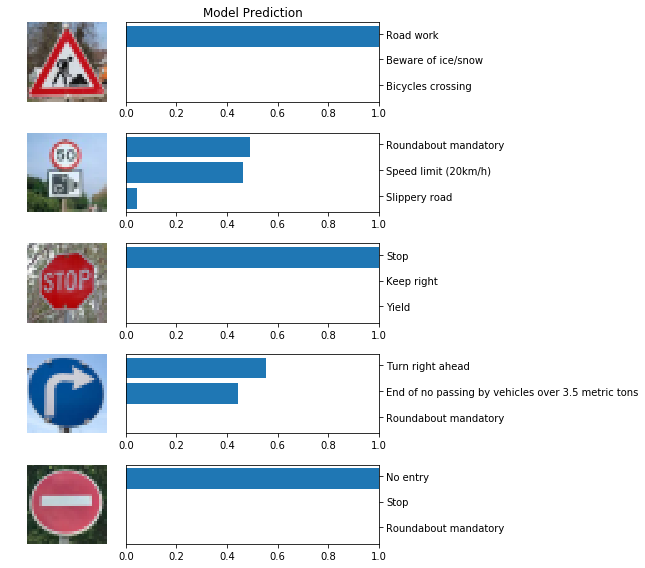

In [164]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
fig, ax = plt.subplots(5, 2, figsize=(10, 8))
bar_locations = np.arange(5)[::-1]

for i, img in enumerate(new_data):
    
    prob_ = probs[i]
    predict_ = indices[i]
    names = [sign_names.iloc[l]['SignName'] for l in predict_]
 
    ax[i,0].imshow(new_data[i])
    ax[i,0].axis('off')
    ax[i,1].barh(bar_locations, prob_)
    ax[i,1].set_yticks(0.1 + bar_locations)
    ax[i,1].set_yticklabels(names)
    ax[i,1].yaxis.tick_right()
    ax[i,1].set_xlim([0,1])
    
ax[0,1].set_title('Model Prediction')
fig.tight_layout()

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [165]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
            

First, we inspect a image from a success predicting case to see what feature map the cnn sees.

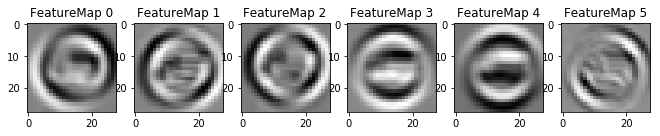

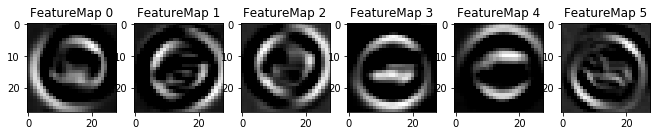

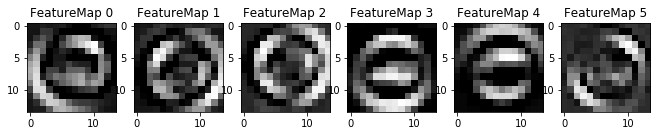

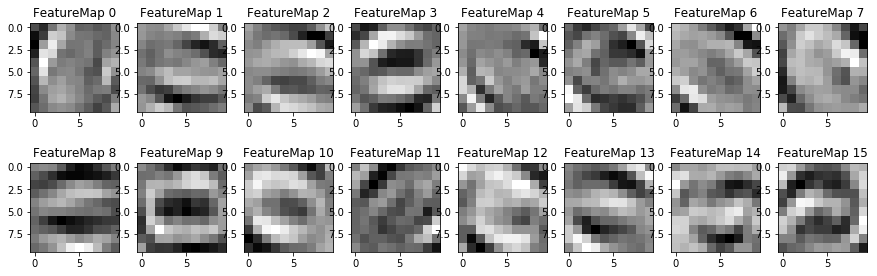

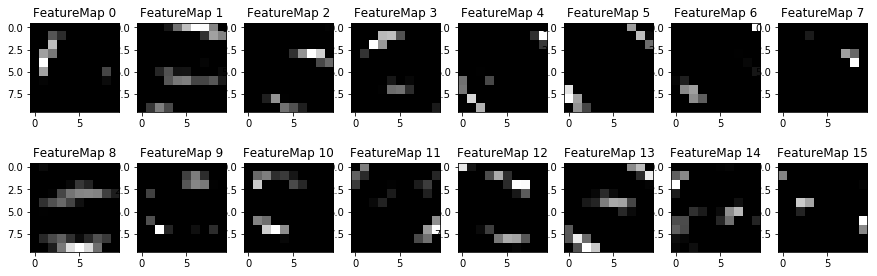

In [179]:
test_image = X_test[0,:,:,:]

with tf.Session() as sess:
    saver.restore(sess, "./lenet")
    sess = tf.get_default_session()
    ops = sess.graph.get_operations()
    #for op in ops:
    #    print (op.name)
    conv1 = sess.graph.get_tensor_by_name('Conv2D:0')
    relu1 = sess.graph.get_tensor_by_name('Relu:0')
    MaxPool1 = sess.graph.get_tensor_by_name('MaxPool:0')
    
    conv2 = sess.graph.get_tensor_by_name('Conv2D_1:0')
    relu2 = sess.graph.get_tensor_by_name('Relu_1:0')
    
    outputFeatureMap([test_image], conv1, plt_num=1)
    outputFeatureMap([test_image], relu1, plt_num=2)
    outputFeatureMap([test_image], MaxPool1, plt_num=3)
    outputFeatureMap([test_image], conv2, plt_num=4)
    outputFeatureMap([test_image], relu2, plt_num=5)


Next, we inspect a image from a wrong predicting case to see what feature map the cnn sees.

In [ ]:
test_image2 = new_data[1]

with tf.Session() as sess:
    saver.restore(sess, "./lenet")
    sess = tf.get_default_session()
    ops = sess.graph.get_operations()
    #for op in ops:
    #    print (op.name)
    conv1 = sess.graph.get_tensor_by_name('Conv2D:0')
    relu1 = sess.graph.get_tensor_by_name('Relu:0')
    MaxPool1 = sess.graph.get_tensor_by_name('MaxPool:0')
    
    conv2 = sess.graph.get_tensor_by_name('Conv2D_1:0')
    relu2 = sess.graph.get_tensor_by_name('Relu_1:0')
    
    outputFeatureMap([test_image2], conv1, plt_num=1)
    outputFeatureMap([test_image2], relu1, plt_num=2)
    outputFeatureMap([test_image2], MaxPool1, plt_num=3)
    outputFeatureMap([test_image2], conv2, plt_num=4)
    outputFeatureMap([test_image2], relu2, plt_num=5)